In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import ResNet101, EfficientNetB0
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras import regularizers
from sklearn.metrics import classification_report, confusion_matrix

# Set a seed for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
dataset_path = '/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Oral Cancer'

oral_normal_path = os.path.join(dataset_path, 'oral_normal')
oral_scc_path = os.path.join(dataset_path, 'oral_scc')

# Count images in each folder
oral_normal_images = len(os.listdir(oral_normal_path))
oral_scc_images = len(os.listdir(oral_scc_path))

print(f"Total oral_normal images: {oral_normal_images}")
print(f"Total oral_scc images: {oral_scc_images}")

Total oral_normal images: 5001
Total oral_scc images: 5001


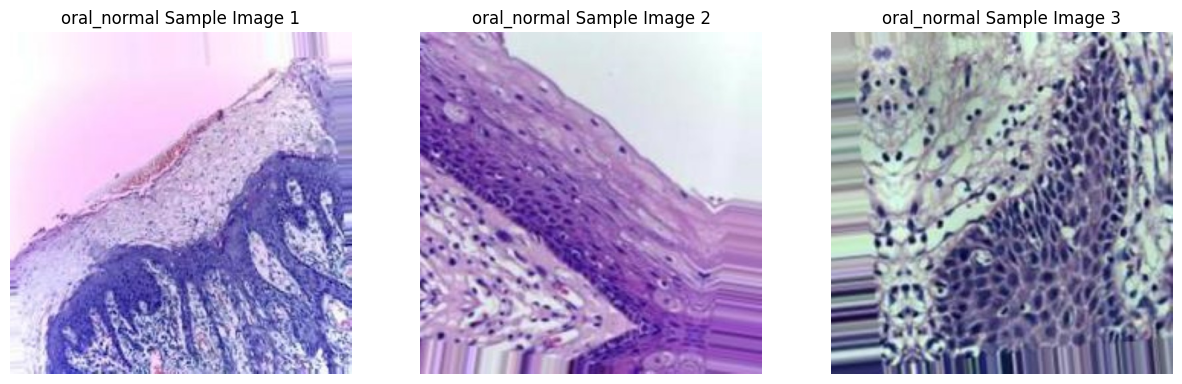

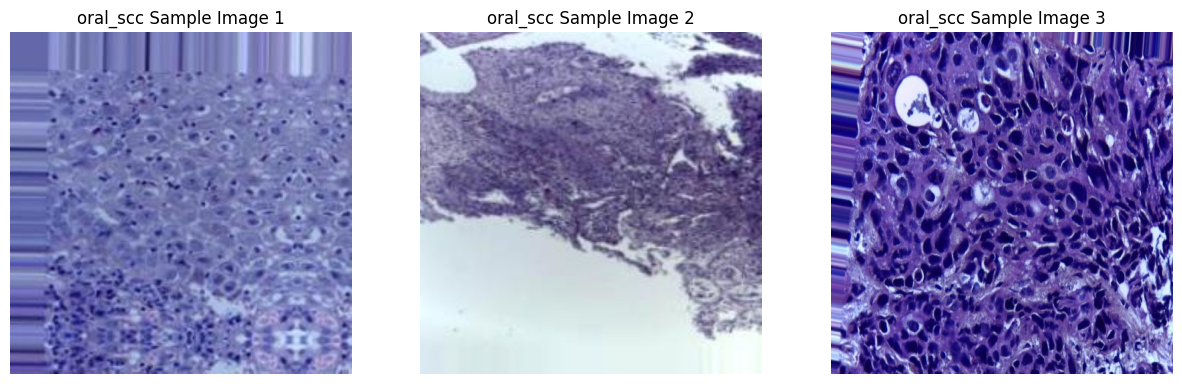

In [3]:
def display_samples(image_paths, title, num_samples=3):
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        img_path = image_paths[i]
        img = cv2.imread(img_path)  # Read the image
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB format
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img_rgb)
        plt.title(f"{title} {i + 1}")
        plt.axis('off')
    plt.show()

# Get all image paths for each category
oral_normal_images_list = os.listdir(oral_normal_path)
oral_scc_images_list = os.listdir(oral_scc_path)

# Display 3 sample images from each category
display_samples([os.path.join(oral_normal_path, img) for img in oral_normal_images_list[:3]], 'oral_normal Sample Image')
display_samples([os.path.join(oral_scc_path, img) for img in oral_scc_images_list[:3]], 'oral_scc Sample Image')

In [4]:
data_dir = '/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer'
target_folder = 'Oral Cancer'
filepath = []
labels = []
all_folder_path = os.path.join(data_dir, target_folder)

if os.path.isdir(all_folder_path):
    filelist = os.listdir(all_folder_path)
    for f in filelist:
        fpath = os.path.join(all_folder_path, f)
        fipath = os.listdir(fpath)
        for image in fipath:
            path = os.path.join(fpath, image)
            filepath.append(path)
            labels.append(f)

f_series = pd.Series(filepath, name='filepath')
l_series = pd.Series(labels, name='labels')
df = pd.concat([f_series, l_series], axis=1)

# Display the first few rows
print(df.head())
print(df.dtypes)
print(df.isnull().sum())
print(df.describe())

                                            filepath    labels
0  /kaggle/input/multi-cancer/Multi Cancer/Multi ...  oral_scc
1  /kaggle/input/multi-cancer/Multi Cancer/Multi ...  oral_scc
2  /kaggle/input/multi-cancer/Multi Cancer/Multi ...  oral_scc
3  /kaggle/input/multi-cancer/Multi Cancer/Multi ...  oral_scc
4  /kaggle/input/multi-cancer/Multi Cancer/Multi ...  oral_scc
filepath    object
labels      object
dtype: object
filepath    0
labels      0
dtype: int64
                                                 filepath    labels
count                                               10002     10002
unique                                              10002         2
top     /kaggle/input/multi-cancer/Multi Cancer/Multi ...  oral_scc
freq                                                    1      5001


In [5]:
strat = df['labels']
train_df, dummy_df = train_test_split(df, test_size=0.3, random_state=42, stratify=strat)
strate = dummy_df['labels']
valid_df, test_df = train_test_split(dummy_df, test_size=0.5, random_state=42, stratify=strate)

print(train_df.shape)
print(valid_df.shape)
print(test_df.shape)

(7001, 2)
(1500, 2)
(1501, 2)


In [6]:
batch_size = 64
img_size = (224, 224)
channels = 3

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepath', y_col='labels', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepath', y_col='labels', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepath', y_col='labels', target_size=img_size,
                                      class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)


Found 7001 validated image filenames belonging to 2 classes.
Found 1500 validated image filenames belonging to 2 classes.
Found 1501 validated image filenames belonging to 2 classes.


In [16]:
base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),
    Dense(2, activation='sigmoid')
])

model.compile(optimizer=Adamax(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet101 (Functional)               │ (None, 7, 7, 2048)          │      42,658,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 43,200,578 (164.80 MB)

 Trainable params: 541,762 (2.07 MB)

 Non-trainable params: 42,658,816 (162.73 MB)

In [10]:
# base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# for layer in base_model.layers:
#     layer.trainable = False

# model2 = Sequential([
#     base_model,
#     GlobalAveragePooling2D(),
#     Dense(256, activation='relu'),
#     BatchNormalization(),
#     Dropout(0.25),
#     Dense(64, activation='relu'),
#     BatchNormalization(),
#     Dropout(0.25),
#     Dense(2, activation='sigmoid')
# ])

# model2.compile(optimizer=Adamax(learning_rate=0.002), loss='binary_crossentropy', metrics=['accuracy'])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [17]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

history = model.fit(
    train_gen,
    epochs=50,
    validation_data=valid_gen,
    shuffle=False,
    callbacks=[early_stopping, model_checkpoint],
)

Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.7271 - loss: 0.5870
Epoch 1: val_loss improved from inf to 0.36020, saving model to best_model.keras
110/110 ━━━━━━━━━━━━━━━━━━━━ 76s 495ms/step - accuracy: 0.7276 - loss: 0.5861 - val_accuracy: 0.8353 - val_loss: 0.3602
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.8657 - loss: 0.3442
Epoch 2: val_loss improved from 0.36020 to 0.30075, saving model to best_model.keras
110/110 ━━━━━━━━━━━━━━━━━━━━ 37s 338ms/step - accuracy: 0.8657 - loss: 0.3441 - val_accuracy: 0.8800 - val_loss: 0.3008
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.8982 - loss: 0.2721
Epoch 3: val_loss improved from 0.30075 to 0.26288, saving model to best_model.keras
110/110 ━━━━━━━━━━━━━━━━━━━━ 38s 346ms/step - accuracy: 0.8983 - loss: 0.2720 - val_accuracy: 0.8987 - val_loss: 0.2629
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.9178 - loss: 0.2207
Epoch 4: val_loss improved from 0.262

In [18]:
# Load the best model from the checkpoint
best_model = load_model('best_model.keras')

# Evaluate on test set
test_loss, test_accuracy = best_model.evaluate(test_gen, verbose=2)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

24/24 - 18s - 751ms/step - accuracy: 0.9414 - loss: 0.1647
Test Loss: 0.1647
Test Accuracy: 0.9414


24/24 ━━━━━━━━━━━━━━━━━━━━ 18s 505ms/step


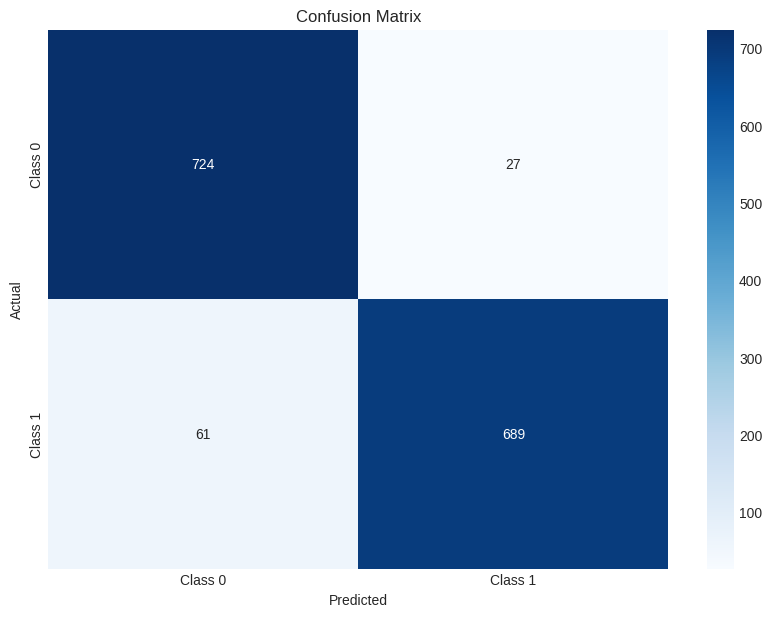

              precision    recall  f1-score   support

     Class 0       0.92      0.96      0.94       751
     Class 1       0.96      0.92      0.94       750

    accuracy                           0.94      1501
   macro avg       0.94      0.94      0.94      1501
weighted avg       0.94      0.94      0.94      1501



In [19]:
y_pred_prob = best_model.predict(test_gen)
y_pred_classes = np.argmax(y_pred_prob, axis=1)
y_true = test_gen.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred_classes, target_names=["Class 0", "Class 1"]))

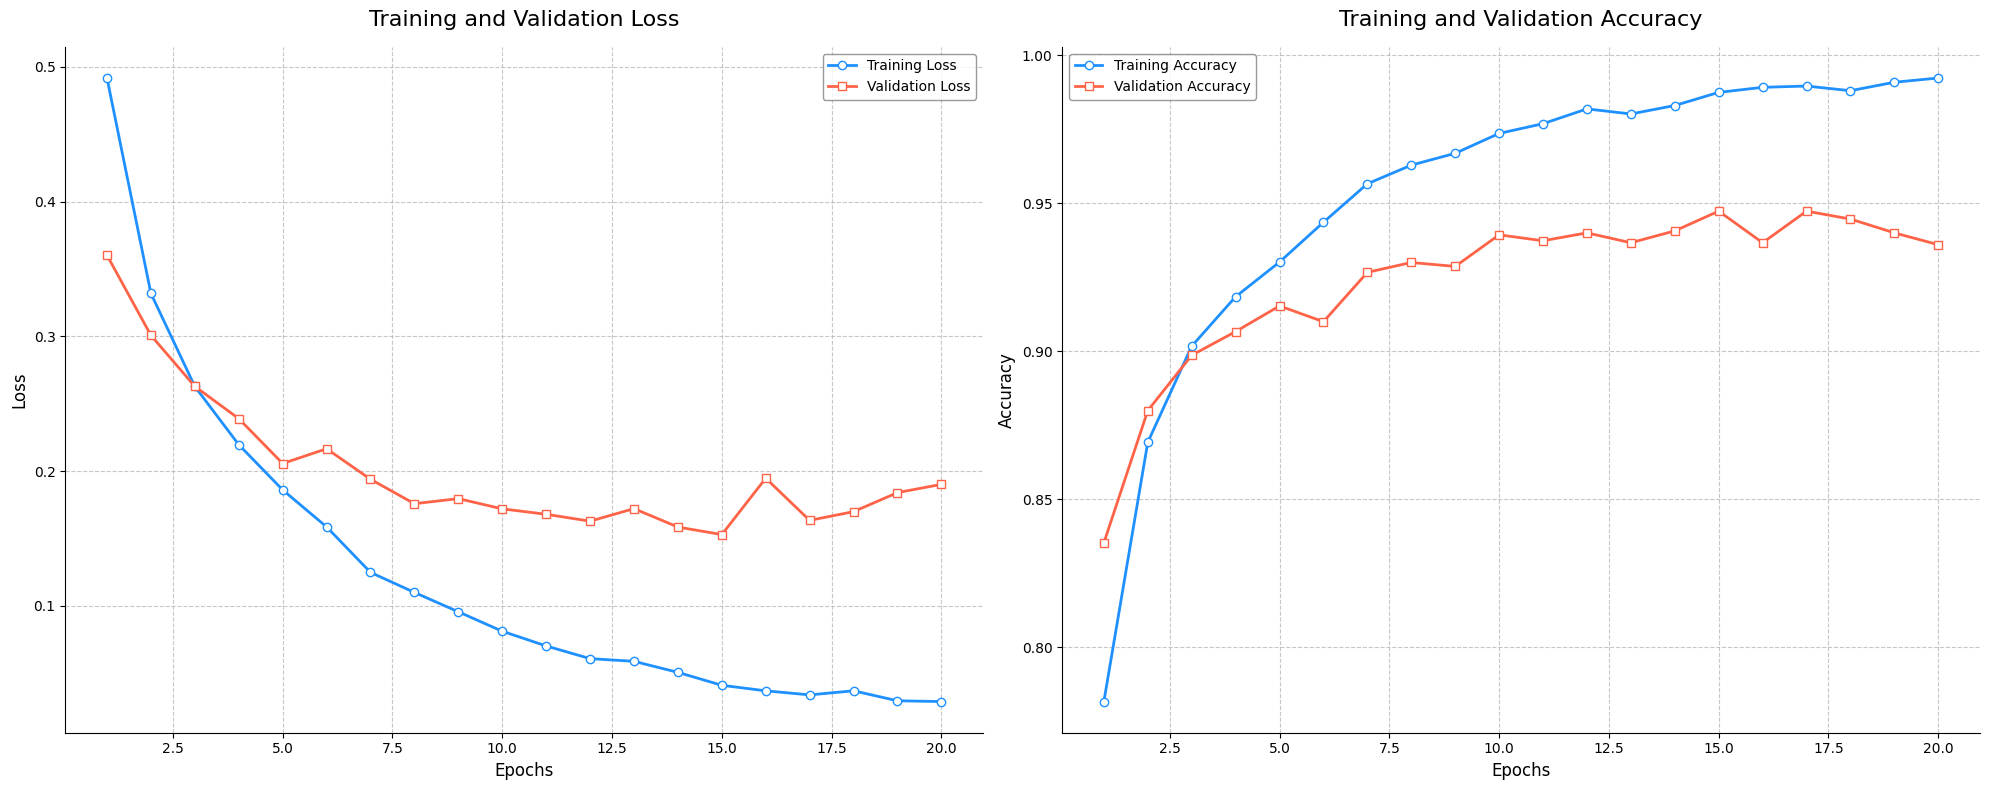

In [21]:
def plot_training_metrics(history, figsize=(20, 8)):
    # Extract metrics
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    epochs = range(1, len(tr_acc) + 1)
    
    # Set up the figure
    plt.style.use('default')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.patch.set_facecolor('white')
    
    # Loss Plot
    ax1.plot(epochs, tr_loss, 'dodgerblue', label='Training Loss', 
             linewidth=2, marker='o', markersize=6, markerfacecolor='white')
    ax1.plot(epochs, val_loss, 'tomato', label='Validation Loss', 
             linewidth=2, marker='s', markersize=6, markerfacecolor='white')
    
    ax1.set_title('Training and Validation Loss', fontsize=16, pad=15)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.legend(fontsize=10, frameon=True, facecolor='white', edgecolor='gray')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    
    # Accuracy Plot
    ax2.plot(epochs, tr_acc, 'dodgerblue', label='Training Accuracy', 
             linewidth=2, marker='o', markersize=6, markerfacecolor='white')
    ax2.plot(epochs, val_acc, 'tomato', label='Validation Accuracy', 
             linewidth=2, marker='s', markersize=6, markerfacecolor='white')
    
    ax2.set_title('Training and Validation Accuracy', fontsize=16, pad=15)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.legend(fontsize=10, frameon=True, facecolor='white', edgecolor='gray')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()

# Usage
plot_training_metrics(history)